# Contents

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Warning message:
"package 'ggplot2' was built under R version 3.5.2"Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
Warning message:
"package 'reshape2' was built under R version 3.5.2"mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following object

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
#     data[, "subj_id"] <- as.factor(data[, "subj_id"])
#     data[, "choice"] <- as.factor(data[, "choice"])
#     
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Checking for max-d unimodality<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [4]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.9675
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.84
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

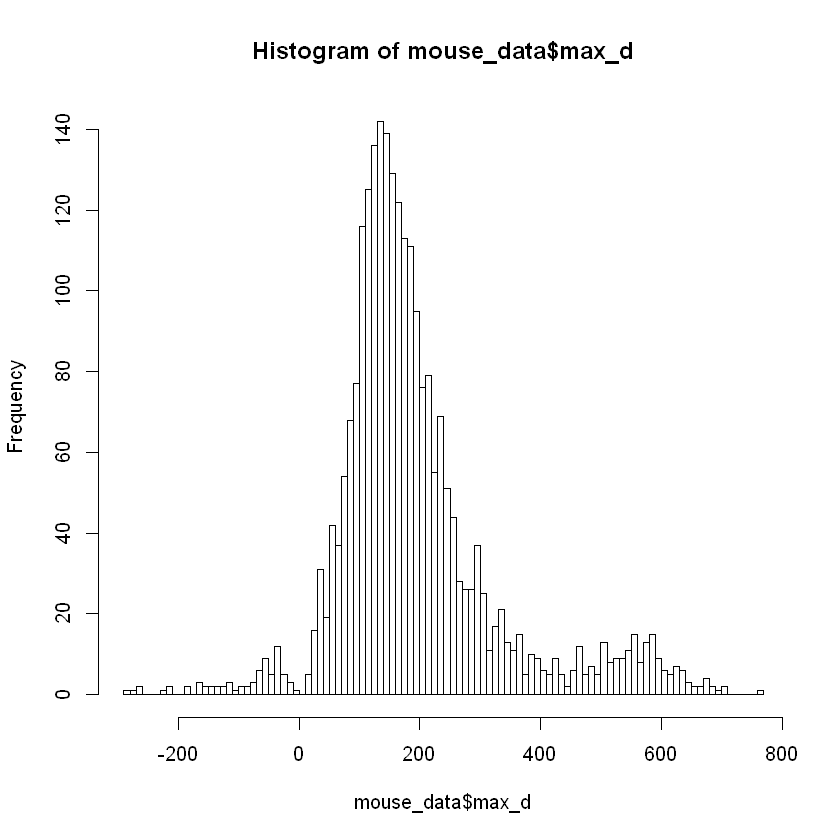

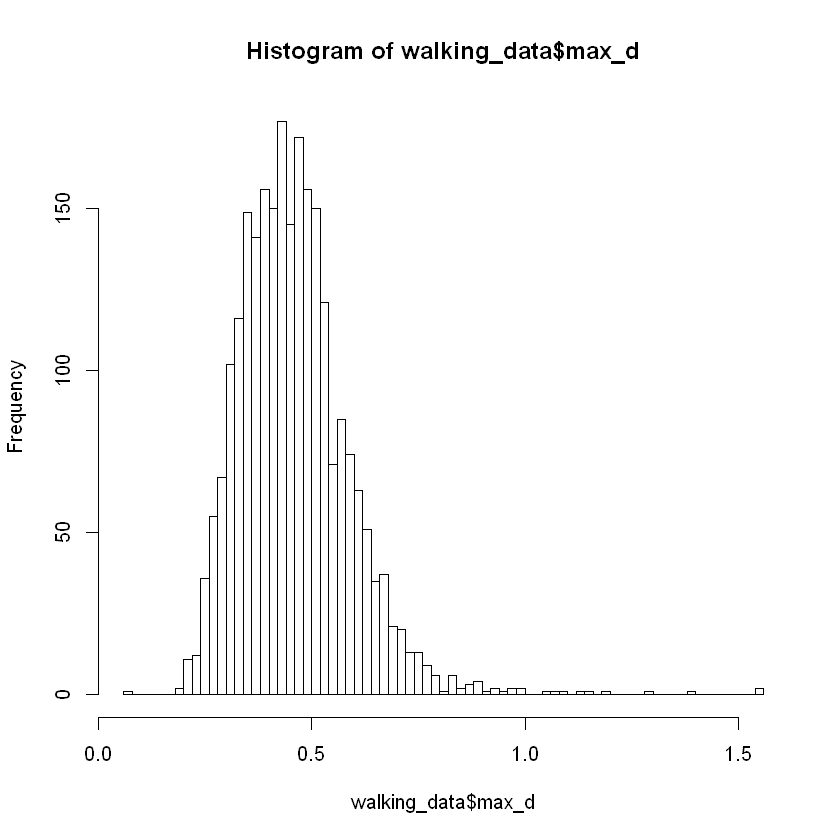

In [5]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [6]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

# Functions for model fitting and BF calculation

In [7]:
get_bf_dyn <- function(data, formulas, prior, n){ 
    " This function fits three models to the supplied data and returns the fitted models and averaged BFs over 10 runs"
    m_inter <- brm(formulas$f_inter, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    m_choice <- brm(formulas$f_choice, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior[1:2,], refresh = 0)
    m_null <- brm(formulas$f_null, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior[1,], refresh = 0)
    
    bfs <- data.frame(double(), double(), double())
    for (i in 1:n) {
        bfs <- rbind(bfs, t(c(bayes_factor(x1 = m_choice, x2 = m_null, silent=TRUE)$bf,
                              bayes_factor(x1 = m_inter, x2 = m_null, silent=TRUE)$bf,
                              bayes_factor(x1 = m_inter, x2 = m_choice, silent=TRUE)$bf)))
    }
    
    colnames(bfs) <- c('bf_task', 'bf_session', 'bf_inter')
    
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf=colMeans(bfs),
                  models = list(m_null = m_null, 
                                m_choice = m_choice, 
                                m_inter = m_inter), 
                  ci_inter = ci_inter)
    
    return(result)
}

run_analysis <- function(dv, iv, data, rscale, n_bf=10){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv); rscale parameter defines the scale of prior distribution 
    on regression slopes (see Rouder & Morey (2012))"    
    interaction_term = paste(iv, "choice", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (choice | subj_id) + choice +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (choice | subj_id) + choice")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"), 
           set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/0.5), class="b", coef = "choiceSS"),
           set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    bf_result <- get_bf_dyn(data, formulas, prior, n=n_bf)
    
    analysis_id <- paste(dv, iv, deparse(substitute(data)))
    
    bf_result$analysis_id <- analysis_id    
    print_bf(bf_result, iv)
    
    return(bf_result)
}

# Functions for visualizing and saving the results

In [8]:
print_bf <- function(bf_result, iv="Delta"){
    print(bf_result$analysis_id)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_choiceLL:", iv, sep=""), 
                         paste("b_choiceSS:", iv, sep=""),
                         "b_choiceSS"),]) 
}

spaghetti_plot <- function(model, data, dv, iv, task, figure_format){
    file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300, 
                                 effects=paste(iv, "choice", sep=":")), 
                plot=FALSE)[[1]]                                                                            
    plt <- plt + 
        geom_point(aes_string(x=iv, y=dv, shape='choice', colour='choice'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 24) +
        ggtitle(paste(task, gsub("_", "-", dv))) +
        theme(plot.title = element_text(hjust = 0.5, size=24, face="plain")) +
        xlab(TeX(paste("$\\", iv, "$", sep=""))) +
        ylab(gsub("_", "-", dv)) +
        theme(legend.position="none") +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    if ((dv == 'RT') & (task == 'walking')){   
        plt <- plt + theme(legend.position = c(0.9, 0.9),
                      legend.title = element_blank(),
                      legend.text = element_text(size=24)) +
                guides(colour = guide_legend(override.aes=list(size = 8, linetype = 0, alpha = 1)))
    }
    ggsave(file.path(figure_path, file_name), dpi=300, width=4, height=4) 
}

save_posterior <- function(model, iv, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", iv, file_name), row.names=FALSE)
}

visualize_result <- function(bf_result, data, task, dv, iv, figure_format){
    print_bf(bf_result, iv)
    spaghetti_plot(bf_result$models$m_inter, data, dv, iv, task, figure_format)
    save_posterior(bf_result$models$m_inter, iv, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
}

# Functions for aggregating the results

In [9]:
save_all_plots <- function(results, iv){
    visualize_result(results$walking_max_d_bf, walking_data, "walking", "max_d", iv, figure_format)
    visualize_result(results$walking_rt_bf, walking_data, "walking", "RT", iv, figure_format)
    visualize_result(results$mouse_max_d_bf, mouse_data, "mouse", "max_d", iv, figure_format)
    visualize_result(results$mouse_rt_bf, mouse_data, "mouse", "RT", iv, figure_format)
    
    visualize_result(results$walking_max_d_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    visualize_result(results$walking_rt_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
    visualize_result(results$mouse_max_d_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    visualize_result(results$mouse_rt_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format)
}

run_all_analyses <- function(iv, rscale){  
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, rscale)
    walking_rt_bf <- run_analysis("RT", iv, walking_data, rscale)
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, rscale)
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, rscale)

    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, rscale)
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, rscale)
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, rscale)        
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, rscale)    
         
    return(list(walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf,                 
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf,
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf))
}

# Run analyses (takes a lot of time!)

In [10]:
lambda_results <- run_all_analyses("lambda", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.732 seconds (Warm-up)
               19.68 seconds (Sampling)
               53.412 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.686 seconds (Warm-up)
               19.786 seconds (Sampling)
               60.472 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.771 seconds (Warm-up)
               13.089 seconds (Sampling)
               47.86 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.107 seconds (Warm-up)
               17.214 seconds (Sampling)
               45.321 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.18 seconds (Warm-up)
               19.601 seconds (Sampling)
               47.781 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.467 seconds (Warm-up)
               15.474 seconds (Sampling)
               41.941 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.225

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.496 seconds (Warm-up)
               4.262 seconds (Sampling)
               11.758 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.028 seconds (Warm-up)
               4.243 seconds (Sampling)
               11.271 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.71 seconds (Warm-up)
               2.292 seconds (Sampling)
               9.002 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.435 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.284 seconds (Warm-up)
               22.79 seconds (Sampling)
               61.074 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.318 seconds (Warm-up)
               26.988 seconds (Sampling)
               63.306 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.659 seconds (Warm-up)
               23.278 seconds (Sampling)
               58.937 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.091 seconds (Warm-up)
               20.762 seconds (Sampling)
               48.853 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.887 seconds (Warm-up)
               21.315 seconds (Sampling)
               50.202 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.627 seconds (Warm-up)
               20.743 seconds (Sampling)
               51.37 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.123 seconds (Warm-up)
               4.415 seconds (Sampling)
               10.538 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.893 seconds (Warm-up)
               4.186 seconds (Sampling)
               10.079 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.84 seconds (Warm-up)
               4.346 seconds (Sampling)
               9.186 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.87 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.336 seconds (Warm-up)
               17.053 seconds (Sampling)
               41.389 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.853 seconds (Warm-up)
               11.762 seconds (Sampling)
               36.615 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.545 seconds (Warm-up)
               12.704 seconds (Sampling)
               32.249 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.648 seconds (Warm-up)
               11.543 seconds (Sampling)
               35.191 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.782 seconds (Warm-up)
               12.244 seconds (Sampling)
               37.026 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.878 seconds (Warm-up)
               14.317 seconds (Sampling)
               41.195 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.46

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.352 seconds (Warm-up)
               4.395 seconds (Sampling)
               10.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.378 seconds (Warm-up)
               4.232 seconds (Sampling)
               9.61 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.998 seconds (Warm-up)
               4.371 seconds (Sampling)
               9.369 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.577 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.974 seconds (Warm-up)
               12.873 seconds (Sampling)
               37.847 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.402 seconds (Warm-up)
               20.553 seconds (Sampling)
               44.955 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.425 seconds (Warm-up)
               13.013 seconds (Sampling)
               38.438 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.031 seconds (Warm-up)
               11.534 seconds (Sampling)
               32.565 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.42 seconds (Warm-up)
               11.677 seconds (Sampling)
               32.097 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.665 seconds (Warm-up)
               17.992 seconds (Sampling)
               42.657 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.685 seconds (Warm-up)
               4.403 seconds (Sampling)
               9.088 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.07 seconds (Warm-up)
               2.402 seconds (Sampling)
               7.472 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.139 seconds (Warm-up)
               3.119 seconds (Sampling)
               8.258 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.59 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 44.12 seconds (Warm-up)
               13.998 seconds (Sampling)
               58.118 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.128 seconds (Warm-up)
               21.636 seconds (Sampling)
               56.764 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.542 seconds (Warm-up)
               22.727 seconds (Sampling)
               55.269 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.215 seconds (Warm-up)
               18.669 seconds (Sampling)
               53.884 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.626 seconds (Warm-up)
               20.641 seconds (Sampling)
               61.267 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.552 seconds (Warm-up)
               16.858 seconds (Sampling)
               46.41 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.373 seconds (Warm-up)
               3.69 seconds (Sampling)
               12.063 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.438 seconds (Warm-up)
               4.276 seconds (Sampling)
               11.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.764 seconds (Warm-up)
               4.162 seconds (Sampling)
               11.926 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.352 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.486 seconds (Warm-up)
               23.058 seconds (Sampling)
               56.544 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.087 seconds (Warm-up)
               21.526 seconds (Sampling)
               60.613 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.784 seconds (Warm-up)
               22.198 seconds (Sampling)
               59.982 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.33

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.949 seconds (Warm-up)
               21.109 seconds (Sampling)
               49.058 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.679 seconds (Warm-up)
               22.682 seconds (Sampling)
               52.361 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.732 seconds (Warm-up)
               22.28 seconds (Sampling)
               55.012 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.274

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.712 seconds (Warm-up)
               4.299 seconds (Sampling)
               9.011 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.039 seconds (Warm-up)
               4.259 seconds (Sampling)
               9.298 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.191 seconds (Warm-up)
               4.338 seconds (Sampling)
               9.529 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.783 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.239 seconds (Warm-up)
               18.841 seconds (Sampling)
               45.08 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.163 seconds (Warm-up)
               12.611 seconds (Sampling)
               41.774 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.705 seconds (Warm-up)
               13.782 seconds (Sampling)
               40.487 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.943

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.809 seconds (Warm-up)
               17.257 seconds (Sampling)
               42.066 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.473 seconds (Warm-up)
               11.692 seconds (Sampling)
               36.165 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.406 seconds (Warm-up)
               18.241 seconds (Sampling)
               42.647 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.77

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.133 seconds (Warm-up)
               4.022 seconds (Sampling)
               9.155 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.094 seconds (Warm-up)
               3.995 seconds (Sampling)
               9.089 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.697 seconds (Warm-up)
               4.017 seconds (Sampling)
               9.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.12 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.373 seconds (Warm-up)
               18.118 seconds (Sampling)
               42.491 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.711 seconds (Warm-up)
               18.465 seconds (Sampling)
               43.176 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.058 seconds (Warm-up)
               14.105 seconds (Sampling)
               36.163 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.385 seconds (Warm-up)
               17.836 seconds (Sampling)
               41.221 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.362 seconds (Warm-up)
               17.667 seconds (Sampling)
               36.029 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.824 seconds (Warm-up)
               9.96 seconds (Sampling)
               28.784 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.43 seconds (Warm-up)
               3.481 seconds (Sampling)
               7.911 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.394 seconds (Warm-up)
               2.931 seconds (Sampling)
               7.325 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.823 seconds (Warm-up)
               3.998 seconds (Sampling)
               7.821 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.802 seconds (

In [13]:
delta_results <- run_all_analyses("Delta", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.975 seconds (Warm-up)
               21.206 seconds (Sampling)
               55.181 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.248 seconds (Warm-up)
               12.214 seconds (Sampling)
               39.462 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.723 seconds (Warm-up)
               14.655 seconds (Sampling)
               44.378 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.456 seconds (Warm-up)
               12.548 seconds (Sampling)
               36.004 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.74 seconds (Warm-up)
               13.211 seconds (Sampling)
               40.951 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.323 seconds (Warm-up)
               19.505 seconds (Sampling)
               47.828 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.156 seconds (Warm-up)
               4.529 seconds (Sampling)
               11.685 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 12.019 seconds (Warm-up)
               4.585 seconds (Sampling)
               16.604 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.817 seconds (Warm-up)
               2.576 seconds (Sampling)
               9.393 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.771 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.214 seconds (Warm-up)
               47.658 seconds (Sampling)
               85.872 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.028 seconds (Warm-up)
               34.06 seconds (Sampling)
               70.088 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.505 seconds (Warm-up)
               22.44 seconds (Sampling)
               60.945 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.755 

Warning message:
"There were 5 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.906 seconds (Warm-up)
               21.531 seconds (Sampling)
               53.437 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.19 seconds (Warm-up)
               21.57 seconds (Sampling)
               51.76 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.085 seconds (Warm-up)
               22.086 seconds (Sampling)
               53.171 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.885 s

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.43 seconds (Warm-up)
               7.081 seconds (Sampling)
               12.511 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.625 seconds (Warm-up)
               4.362 seconds (Sampling)
               8.987 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.709 seconds (Warm-up)
               4.923 seconds (Sampling)
               10.632 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.379 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.308 seconds (Warm-up)
               12.03 seconds (Sampling)
               38.338 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.185 seconds (Warm-up)
               19.633 seconds (Sampling)
               42.818 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.856 seconds (Warm-up)
               12.838 seconds (Sampling)
               37.694 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.693 seconds (Warm-up)
               16.199 seconds (Sampling)
               34.892 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.701 seconds (Warm-up)
               15.988 seconds (Sampling)
               38.689 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.4 seconds (Warm-up)
               11.059 seconds (Sampling)
               31.459 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.929 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.366 seconds (Warm-up)
               2.215 seconds (Sampling)
               6.581 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.175 seconds (Warm-up)
               4.28 seconds (Sampling)
               8.455 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.261 seconds (Warm-up)
               4.262 seconds (Sampling)
               10.523 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.132 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.94 seconds (Warm-up)
               11.114 seconds (Sampling)
               32.054 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.398 seconds (Warm-up)
               11.237 seconds (Sampling)
               32.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.899 seconds (Warm-up)
               12.375 seconds (Sampling)
               36.274 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.766

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.548 seconds (Warm-up)
               13.968 seconds (Sampling)
               32.516 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.007 seconds (Warm-up)
               11.28 seconds (Sampling)
               33.287 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.042 seconds (Warm-up)
               13.33 seconds (Sampling)
               34.372 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.873 seconds (Warm-up)
               4.344 seconds (Sampling)
               9.217 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.452 seconds (Warm-up)
               4.276 seconds (Sampling)
               9.728 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.803 seconds (Warm-up)
               2.198 seconds (Sampling)
               7.001 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.07 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.781 seconds (Warm-up)
               15.285 seconds (Sampling)
               44.066 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.849 seconds (Warm-up)
               20.349 seconds (Sampling)
               54.198 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.843 seconds (Warm-up)
               15.123 seconds (Sampling)
               47.966 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.08

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.705 seconds (Warm-up)
               16.024 seconds (Sampling)
               46.729 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.496 seconds (Warm-up)
               14.096 seconds (Sampling)
               41.592 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.236 seconds (Warm-up)
               15.216 seconds (Sampling)
               44.452 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.84

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.504 seconds (Warm-up)
               4.418 seconds (Sampling)
               12.922 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.394 seconds (Warm-up)
               4.029 seconds (Sampling)
               11.423 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.174 seconds (Warm-up)
               3.659 seconds (Sampling)
               10.833 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.845 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.505 seconds (Warm-up)
               21.535 seconds (Sampling)
               53.04 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.344 seconds (Warm-up)
               21.626 seconds (Sampling)
               52.97 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.193 seconds (Warm-up)
               24.089 seconds (Sampling)
               56.282 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.769 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.514 seconds (Warm-up)
               21.6 seconds (Sampling)
               52.114 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.246 seconds (Warm-up)
               20.826 seconds (Sampling)
               49.072 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.463 seconds (Warm-up)
               23.372 seconds (Sampling)
               53.835 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.431 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.193 seconds (Warm-up)
               4.383 seconds (Sampling)
               10.576 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.65 seconds (Warm-up)
               3.029 seconds (Sampling)
               7.679 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.129 seconds (Warm-up)
               8.337 seconds (Sampling)
               13.466 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.323 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.573 seconds (Warm-up)
               13.58 seconds (Sampling)
               36.153 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.539 seconds (Warm-up)
               12.563 seconds (Sampling)
               34.102 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.941 seconds (Warm-up)
               20.232 seconds (Sampling)
               41.173 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.45 seconds (Warm-up)
               14.309 seconds (Sampling)
               36.759 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.33 seconds (Warm-up)
               19.156 seconds (Sampling)
               42.486 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.172 seconds (Warm-up)
               18.675 seconds (Sampling)
               44.847 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.114 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.654 seconds (Warm-up)
               2.462 seconds (Sampling)
               9.116 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.943 seconds (Warm-up)
               3.958 seconds (Sampling)
               8.901 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.094 seconds (Warm-up)
               3.016 seconds (Sampling)
               8.11 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.303 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.421 seconds (Warm-up)
               17.953 seconds (Sampling)
               40.374 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.091 seconds (Warm-up)
               15.272 seconds (Sampling)
               35.363 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.958 seconds (Warm-up)
               18.602 seconds (Sampling)
               40.56 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.006 seconds (Warm-up)
               12.671 seconds (Sampling)
               31.677 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.653 seconds (Warm-up)
               18.67 seconds (Sampling)
               39.323 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.409 seconds (Warm-up)
               17.364 seconds (Sampling)
               35.773 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.666 seconds (Warm-up)
               3.245 seconds (Sampling)
               6.911 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.21 seconds (Warm-up)
               2.606 seconds (Sampling)
               5.816 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.133 seconds (Warm-up)
               3.972 seconds (Sampling)
               8.105 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.534 seconds (

# Check sensitivity of BFs to the scale of priors

In [17]:
lambda_results_narrow_priors <- run_all_analyses("lambda", rscale=0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.732 seconds (Warm-up)
               11.974 seconds (Sampling)
               43.706 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 49.212 seconds (Warm-up)
               12.201 seconds (Sampling)
               61.413 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.754 seconds (Warm-up)
               11.63 seconds (Sampling)
               44.384 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.737 seconds (Warm-up)
               11.894 seconds (Sampling)
               38.631 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.151 seconds (Warm-up)
               11.477 seconds (Sampling)
               39.628 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.443 seconds (Warm-up)
               17.346 seconds (Sampling)
               42.789 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.87

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.06 seconds (Warm-up)
               2.609 seconds (Sampling)
               10.669 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.138 seconds (Warm-up)
               2.187 seconds (Sampling)
               9.325 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.85 seconds (Warm-up)
               4.077 seconds (Sampling)
               11.927 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.797 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.414 seconds (Warm-up)
               24.636 seconds (Sampling)
               59.05 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.132 seconds (Warm-up)
               23.079 seconds (Sampling)
               59.211 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.758 seconds (Warm-up)
               23.733 seconds (Sampling)
               54.491 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.13 seconds (Warm-up)
               20.539 seconds (Sampling)
               50.669 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.891 seconds (Warm-up)
               21.28 seconds (Sampling)
               53.171 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.36 seconds (Warm-up)
               20.669 seconds (Sampling)
               52.029 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.329 seconds (Warm-up)
               6.005 seconds (Sampling)
               11.334 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.516 seconds (Warm-up)
               3.042 seconds (Sampling)
               8.558 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.187 seconds (Warm-up)
               4.416 seconds (Sampling)
               9.603 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.938 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.13 seconds (Warm-up)
               12.597 seconds (Sampling)
               39.727 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.113 seconds (Warm-up)
               22.99 seconds (Sampling)
               47.103 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.247 seconds (Warm-up)
               17.511 seconds (Sampling)
               45.758 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.275 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.095 seconds (Warm-up)
               11.248 seconds (Sampling)
               36.343 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.467 seconds (Warm-up)
               11.522 seconds (Sampling)
               33.989 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.142 seconds (Warm-up)
               11.018 seconds (Sampling)
               32.16 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.807

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.88 seconds (Warm-up)
               4.433 seconds (Sampling)
               9.313 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.748 seconds (Warm-up)
               4.314 seconds (Sampling)
               9.062 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.574 seconds (Warm-up)
               4.213 seconds (Sampling)
               8.787 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.903 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.142 seconds (Warm-up)
               18.571 seconds (Sampling)
               42.713 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.065 seconds (Warm-up)
               20.877 seconds (Sampling)
               46.942 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.655 seconds (Warm-up)
               13.853 seconds (Sampling)
               41.508 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.68

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.36 seconds (Warm-up)
               21.689 seconds (Sampling)
               42.049 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.059 seconds (Warm-up)
               10.82 seconds (Sampling)
               31.879 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.323 seconds (Warm-up)
               14.03 seconds (Sampling)
               34.353 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.929 seconds (Warm-up)
               2.735 seconds (Sampling)
               7.664 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.471 seconds (Warm-up)
               4.202 seconds (Sampling)
               8.673 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.264 seconds (Warm-up)
               4.262 seconds (Sampling)
               8.526 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.569 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.677 seconds (Warm-up)
               18.045 seconds (Sampling)
               54.722 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 45.842 seconds (Warm-up)
               12.637 seconds (Sampling)
               58.479 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.183 seconds (Warm-up)
               14.132 seconds (Sampling)
               54.315 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 45.042 seconds (Warm-up)
               12.547 seconds (Sampling)
               57.589 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.424 seconds (Warm-up)
               11.762 seconds (Sampling)
               41.186 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.575 seconds (Warm-up)
               19.153 seconds (Sampling)
               49.728 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.739 seconds (Warm-up)
               2.85 seconds (Sampling)
               10.589 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.194 seconds (Warm-up)
               4.172 seconds (Sampling)
               11.366 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.87 seconds (Warm-up)
               3.75 seconds (Sampling)
               11.62 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.448 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.778 seconds (Warm-up)
               44.119 seconds (Sampling)
               78.897 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.214 seconds (Warm-up)
               26.2 seconds (Sampling)
               63.414 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.441 seconds (Warm-up)
               22.292 seconds (Sampling)
               57.733 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.533 seconds (Warm-up)
               20.896 seconds (Sampling)
               56.429 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.444 seconds (Warm-up)
               20.952 seconds (Sampling)
               54.396 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.672 seconds (Warm-up)
               41.256 seconds (Sampling)
               71.928 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.037 seconds (Warm-up)
               4.778 seconds (Sampling)
               9.815 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.243 seconds (Warm-up)
               4.068 seconds (Sampling)
               9.311 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.504 seconds (Warm-up)
               4.969 seconds (Sampling)
               9.473 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.949 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.372 seconds (Warm-up)
               20.239 seconds (Sampling)
               44.611 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.005 seconds (Warm-up)
               11.875 seconds (Sampling)
               37.88 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.095 seconds (Warm-up)
               14.368 seconds (Sampling)
               34.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.283 seconds (Warm-up)
               18.636 seconds (Sampling)
               41.919 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.233 seconds (Warm-up)
               12.554 seconds (Sampling)
               31.787 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.085 seconds (Warm-up)
               14.168 seconds (Sampling)
               36.253 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.13

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.097 seconds (Warm-up)
               4.015 seconds (Sampling)
               9.112 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.184 seconds (Warm-up)
               2.78 seconds (Sampling)
               7.964 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.696 seconds (Warm-up)
               2.066 seconds (Sampling)
               8.762 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.654 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.124 seconds (Warm-up)
               19.372 seconds (Sampling)
               43.496 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.518 seconds (Warm-up)
               18.786 seconds (Sampling)
               43.304 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.613 seconds (Warm-up)
               18.806 seconds (Sampling)
               43.419 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.198 seconds (Warm-up)
               17.826 seconds (Sampling)
               38.024 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.097 seconds (Warm-up)
               9.683 seconds (Sampling)
               28.78 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.85 seconds (Warm-up)
               10.187 seconds (Sampling)
               30.037 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.321 seconds (Warm-up)
               3.976 seconds (Sampling)
               8.297 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.087 seconds (Warm-up)
               3.866 seconds (Sampling)
               7.953 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.152 seconds (Warm-up)
               3.997 seconds (Sampling)
               8.149 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.214 sec

In [18]:
lambda_results_wide_priors <- run_all_analyses("lambda", rscale=1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.881 seconds (Warm-up)
               12.649 seconds (Sampling)
               48.53 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.623 seconds (Warm-up)
               12.316 seconds (Sampling)
               47.939 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.355 seconds (Warm-up)
               12.403 seconds (Sampling)
               44.758 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 48.766

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.306 seconds (Warm-up)
               10.656 seconds (Sampling)
               37.962 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.255 seconds (Warm-up)
               20.859 seconds (Sampling)
               44.114 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.084 seconds (Warm-up)
               12.162 seconds (Sampling)
               38.246 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.622 seconds (Warm-up)
               2.153 seconds (Sampling)
               7.775 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.465 seconds (Warm-up)
               3.785 seconds (Sampling)
               11.25 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.133 seconds (Warm-up)
               2.385 seconds (Sampling)
               10.518 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.738 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.74 seconds (Warm-up)
               25.185 seconds (Sampling)
               60.925 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.276 seconds (Warm-up)
               23.207 seconds (Sampling)
               58.483 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.503 seconds (Warm-up)
               22.433 seconds (Sampling)
               56.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.522 seconds (Warm-up)
               21.879 seconds (Sampling)
               51.401 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.703 seconds (Warm-up)
               23.425 seconds (Sampling)
               53.128 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.117 seconds (Warm-up)
               21.069 seconds (Sampling)
               55.186 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.841 seconds (Warm-up)
               5.034 seconds (Sampling)
               10.875 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.252 seconds (Warm-up)
               4.514 seconds (Sampling)
               9.766 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.291 seconds (Warm-up)
               4.525 seconds (Sampling)
               9.816 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.61 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.676 seconds (Warm-up)
               11.859 seconds (Sampling)
               31.535 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.571 seconds (Warm-up)
               11.462 seconds (Sampling)
               35.033 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.935 seconds (Warm-up)
               16.017 seconds (Sampling)
               44.952 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.732 seconds (Warm-up)
               18.023 seconds (Sampling)
               40.755 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.276 seconds (Warm-up)
               14.753 seconds (Sampling)
               37.029 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.464 seconds (Warm-up)
               16.715 seconds (Sampling)
               40.179 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.13 seconds (Warm-up)
               4.813 seconds (Sampling)
               10.943 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.504 seconds (Warm-up)
               3.674 seconds (Sampling)
               8.178 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.283 seconds (Warm-up)
               4.409 seconds (Sampling)
               9.692 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.503 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.804 seconds (Warm-up)
               12.49 seconds (Sampling)
               36.294 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.637 seconds (Warm-up)
               15.951 seconds (Sampling)
               40.588 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.054 seconds (Warm-up)
               20.118 seconds (Sampling)
               46.172 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.608 seconds (Warm-up)
               12.257 seconds (Sampling)
               32.865 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.799 seconds (Warm-up)
               18.588 seconds (Sampling)
               57.387 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.098 seconds (Warm-up)
               17.004 seconds (Sampling)
               37.102 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.185 seconds (Warm-up)
               4.334 seconds (Sampling)
               9.519 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.398 seconds (Warm-up)
               2.375 seconds (Sampling)
               6.773 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.869 seconds (Warm-up)
               4.404 seconds (Sampling)
               9.273 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.955 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.784 seconds (Warm-up)
               20.598 seconds (Sampling)
               58.382 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.801 seconds (Warm-up)
               13.95 seconds (Sampling)
               49.751 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 50.14 seconds (Warm-up)
               13.222 seconds (Sampling)
               63.362 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.759 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.469 seconds (Warm-up)
               21.115 seconds (Sampling)
               54.584 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.266 seconds (Warm-up)
               16.45 seconds (Sampling)
               44.716 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.524 seconds (Warm-up)
               15.096 seconds (Sampling)
               54.62 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.376 seconds (Warm-up)
               2.183 seconds (Sampling)
               9.559 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.641 seconds (Warm-up)
               4.22 seconds (Sampling)
               12.861 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.757 seconds (Warm-up)
               4.266 seconds (Sampling)
               12.023 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.884 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.047 seconds (Warm-up)
               26.466 seconds (Sampling)
               63.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.879 seconds (Warm-up)
               21.704 seconds (Sampling)
               56.583 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.281 seconds (Warm-up)
               21.756 seconds (Sampling)
               58.037 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.95

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.785 seconds (Warm-up)
               20.833 seconds (Sampling)
               51.618 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.673 seconds (Warm-up)
               28.371 seconds (Sampling)
               57.044 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.123 seconds (Warm-up)
               20.518 seconds (Sampling)
               50.641 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.055 seconds (Warm-up)
               4.31 seconds (Sampling)
               9.365 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.942 seconds (Warm-up)
               4.307 seconds (Sampling)
               9.249 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.044 seconds (Warm-up)
               4.385 seconds (Sampling)
               10.429 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.665 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.958 seconds (Warm-up)
               13.097 seconds (Sampling)
               34.055 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.134 seconds (Warm-up)
               19.327 seconds (Sampling)
               44.461 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.55 seconds (Warm-up)
               12.787 seconds (Sampling)
               34.337 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.362

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.52 seconds (Warm-up)
               18.59 seconds (Sampling)
               45.11 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.511 seconds (Warm-up)
               18.302 seconds (Sampling)
               42.813 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.97 seconds (Warm-up)
               19.063 seconds (Sampling)
               44.033 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time:

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.305 seconds (Warm-up)
               3.487 seconds (Sampling)
               7.792 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.598 seconds (Warm-up)
               4.199 seconds (Sampling)
               9.797 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.962 seconds (Warm-up)
               2.625 seconds (Sampling)
               7.587 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.395 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.104 seconds (Warm-up)
               18.398 seconds (Sampling)
               44.502 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.024 seconds (Warm-up)
               15.398 seconds (Sampling)
               43.422 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.28 seconds (Warm-up)
               17.434 seconds (Sampling)
               39.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.436

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.67 seconds (Warm-up)
               10.489 seconds (Sampling)
               32.159 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.192 seconds (Warm-up)
               9.943 seconds (Sampling)
               29.135 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.068 seconds (Warm-up)
               17.17 seconds (Sampling)
               37.238 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.451 seconds (Warm-up)
               2.377 seconds (Sampling)
               6.828 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.246 seconds (Warm-up)
               4.415 seconds (Sampling)
               8.661 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.239 seconds (Warm-up)
               2.246 seconds (Sampling)
               6.485 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.315 seconds 

In [19]:
delta_results_narrow_priors <- run_all_analyses("Delta", rscale=0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.465 seconds (Warm-up)
               13.306 seconds (Sampling)
               40.771 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.94 seconds (Warm-up)
               12.033 seconds (Sampling)
               37.973 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.834 seconds (Warm-up)
               20.564 seconds (Sampling)
               51.398 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.929

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.421 seconds (Warm-up)
               11.271 seconds (Sampling)
               40.692 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.973 seconds (Warm-up)
               12.502 seconds (Sampling)
               40.475 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.503 seconds (Warm-up)
               11.662 seconds (Sampling)
               39.165 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.89

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.098 seconds (Warm-up)
               3.509 seconds (Sampling)
               10.607 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.045 seconds (Warm-up)
               3.174 seconds (Sampling)
               11.219 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.116 seconds (Warm-up)
               2.387 seconds (Sampling)
               9.503 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.177 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.413 seconds (Warm-up)
               33.149 seconds (Sampling)
               69.562 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.658 seconds (Warm-up)
               26.186 seconds (Sampling)
               56.844 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.895 seconds (Warm-up)
               21.845 seconds (Sampling)
               56.74 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Warning message:
"There were 4 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.58 seconds (Warm-up)
               20.698 seconds (Sampling)
               52.278 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.732 seconds (Warm-up)
               26.158 seconds (Sampling)
               56.89 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.295 seconds (Warm-up)
               21.283 seconds (Sampling)
               54.578 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.899 seconds (Warm-up)
               4.509 seconds (Sampling)
               9.408 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.31 seconds (Warm-up)
               4.486 seconds (Sampling)
               9.796 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.779 seconds (Warm-up)
               3.106 seconds (Sampling)
               7.885 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.217 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.033 seconds (Warm-up)
               16.99 seconds (Sampling)
               44.023 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.418 seconds (Warm-up)
               20.322 seconds (Sampling)
               46.74 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.575 seconds (Warm-up)
               11.622 seconds (Sampling)
               39.197 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.748 seconds (Warm-up)
               11.618 seconds (Sampling)
               34.366 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.652 seconds (Warm-up)
               15.617 seconds (Sampling)
               37.269 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.948 seconds (Warm-up)
               16.71 seconds (Sampling)
               37.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.487

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.043 seconds (Warm-up)
               4.366 seconds (Sampling)
               9.409 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.789 seconds (Warm-up)
               4.326 seconds (Sampling)
               9.115 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.273 seconds (Warm-up)
               2.226 seconds (Sampling)
               7.499 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.67 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.24 seconds (Warm-up)
               11.276 seconds (Sampling)
               33.516 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.005 seconds (Warm-up)
               17.282 seconds (Sampling)
               38.287 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.086 seconds (Warm-up)
               11.633 seconds (Sampling)
               34.719 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.267 seconds (Warm-up)
               16.037 seconds (Sampling)
               37.304 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.632 seconds (Warm-up)
               19.471 seconds (Sampling)
               42.103 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.045 seconds (Warm-up)
               16.433 seconds (Sampling)
               36.478 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.122 seconds (Warm-up)
               4.447 seconds (Sampling)
               9.569 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.882 seconds (Warm-up)
               4.119 seconds (Sampling)
               8.001 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.753 seconds (Warm-up)
               4.355 seconds (Sampling)
               9.108 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.969 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.887 seconds (Warm-up)
               15.59 seconds (Sampling)
               51.477 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.177 seconds (Warm-up)
               13.052 seconds (Sampling)
               46.229 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.817 seconds (Warm-up)
               14.444 seconds (Sampling)
               45.261 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.833

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.838 seconds (Warm-up)
               19.373 seconds (Sampling)
               51.211 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.952 seconds (Warm-up)
               11.373 seconds (Sampling)
               37.325 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.572 seconds (Warm-up)
               13.465 seconds (Sampling)
               44.037 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 41.43

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.651 seconds (Warm-up)
               2.213 seconds (Sampling)
               9.864 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.859 seconds (Warm-up)
               2.755 seconds (Sampling)
               10.614 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.764 seconds (Warm-up)
               2.324 seconds (Sampling)
               10.088 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.531 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.565 seconds (Warm-up)
               25.549 seconds (Sampling)
               57.114 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.825 seconds (Warm-up)
               21.46 seconds (Sampling)
               54.285 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.965 seconds (Warm-up)
               46.336 seconds (Sampling)
               77.301 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.217 seconds (Warm-up)
               22.351 seconds (Sampling)
               53.568 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.269 seconds (Warm-up)
               21.325 seconds (Sampling)
               53.594 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.475 seconds (Warm-up)
               22.644 seconds (Sampling)
               56.119 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.704 seconds (Warm-up)
               4.264 seconds (Sampling)
               8.968 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.66 seconds (Warm-up)
               4.265 seconds (Sampling)
               8.925 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.251 seconds (Warm-up)
               4.336 seconds (Sampling)
               9.587 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.898 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.571 seconds (Warm-up)
               18.029 seconds (Sampling)
               45.6 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.532 seconds (Warm-up)
               11.627 seconds (Sampling)
               41.159 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.141 seconds (Warm-up)
               14.402 seconds (Sampling)
               35.543 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.093 seconds (Warm-up)
               11.761 seconds (Sampling)
               30.854 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.097 seconds (Warm-up)
               17.826 seconds (Sampling)
               42.923 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.074 seconds (Warm-up)
               19.275 seconds (Sampling)
               41.349 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.91 seconds (Warm-up)
               3.542 seconds (Sampling)
               11.452 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7 seconds (Warm-up)
               3.793 seconds (Sampling)
               10.793 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.026 seconds (Warm-up)
               5.17 seconds (Sampling)
               11.196 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.571 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.458 seconds (Warm-up)
               10.425 seconds (Sampling)
               29.883 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.224 seconds (Warm-up)
               15.041 seconds (Sampling)
               35.265 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.336 seconds (Warm-up)
               16.851 seconds (Sampling)
               37.187 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.459 seconds (Warm-up)
               19.288 seconds (Sampling)
               39.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.805 seconds (Warm-up)
               18.369 seconds (Sampling)
               41.174 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.728 seconds (Warm-up)
               18.676 seconds (Sampling)
               39.404 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.966 seconds (Warm-up)
               3.995 seconds (Sampling)
               7.961 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.87 seconds (Warm-up)
               4.851 seconds (Sampling)
               9.721 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.255 seconds (Warm-up)
               3.991 seconds (Sampling)
               8.246 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.442 seco

In [20]:
delta_results_wide_priors <- run_all_analyses("Delta", rscale=1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.222 seconds (Warm-up)
               15.926 seconds (Sampling)
               45.148 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.119 seconds (Warm-up)
               17.601 seconds (Sampling)
               45.72 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.562 seconds (Warm-up)
               21.466 seconds (Sampling)
               48.028 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.683 seconds (Warm-up)
               11.723 seconds (Sampling)
               40.406 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.497 seconds (Warm-up)
               19.816 seconds (Sampling)
               50.313 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.014 seconds (Warm-up)
               17.236 seconds (Sampling)
               45.25 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.249 seconds (Warm-up)
               3.853 seconds (Sampling)
               11.102 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.489 seconds (Warm-up)
               4.292 seconds (Sampling)
               11.781 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.208 seconds (Warm-up)
               4.172 seconds (Sampling)
               11.38 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.84 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.697 seconds (Warm-up)
               27.258 seconds (Sampling)
               61.955 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.943 seconds (Warm-up)
               22.423 seconds (Sampling)
               55.366 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.985 seconds (Warm-up)
               22.162 seconds (Sampling)
               54.147 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.592 seconds (Warm-up)
               20.899 seconds (Sampling)
               51.491 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.5 seconds (Warm-up)
               21.241 seconds (Sampling)
               48.741 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.454 seconds (Warm-up)
               38.297 seconds (Sampling)
               69.751 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Warning message:
"There were 6 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.391 seconds (Warm-up)
               7.357 seconds (Sampling)
               12.748 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.336 seconds (Warm-up)
               4.443 seconds (Sampling)
               9.779 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.793 seconds (Warm-up)
               4.124 seconds (Sampling)
               8.917 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.917 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.428 seconds (Warm-up)
               14.549 seconds (Sampling)
               38.977 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.333 seconds (Warm-up)
               15.13 seconds (Sampling)
               37.463 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.625 seconds (Warm-up)
               18.488 seconds (Sampling)
               40.113 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.082

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.472 seconds (Warm-up)
               11.922 seconds (Sampling)
               38.394 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.196 seconds (Warm-up)
               11.483 seconds (Sampling)
               34.679 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.576 seconds (Warm-up)
               11.847 seconds (Sampling)
               31.423 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.919 seconds (Warm-up)
               4.399 seconds (Sampling)
               10.318 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.311 seconds (Warm-up)
               4.479 seconds (Sampling)
               9.79 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.486 seconds (Warm-up)
               2.531 seconds (Sampling)
               9.017 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.401 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.032 seconds (Warm-up)
               11.437 seconds (Sampling)
               30.469 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.848 seconds (Warm-up)
               16.447 seconds (Sampling)
               40.295 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.273 seconds (Warm-up)
               11.861 seconds (Sampling)
               35.134 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.095 seconds (Warm-up)
               14.88 seconds (Sampling)
               35.975 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.062 seconds (Warm-up)
               11.672 seconds (Sampling)
               32.734 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.027 seconds (Warm-up)
               15.979 seconds (Sampling)
               36.006 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.191 seconds (Warm-up)
               4.326 seconds (Sampling)
               8.517 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.751 seconds (Warm-up)
               2.526 seconds (Sampling)
               7.277 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.761 seconds (Warm-up)
               4.383 seconds (Sampling)
               9.144 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.789 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.476 seconds (Warm-up)
               15.122 seconds (Sampling)
               44.598 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.575 seconds (Warm-up)
               15.984 seconds (Sampling)
               47.559 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.729 seconds (Warm-up)
               19.665 seconds (Sampling)
               52.394 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.987 seconds (Warm-up)
               13.259 seconds (Sampling)
               42.246 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.387 seconds (Warm-up)
               19.098 seconds (Sampling)
               48.485 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.194 seconds (Warm-up)
               21.304 seconds (Sampling)
               53.498 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.606 seconds (Warm-up)
               4.271 seconds (Sampling)
               10.877 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.238 seconds (Warm-up)
               3.605 seconds (Sampling)
               19.843 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.962 seconds (Warm-up)
               4.293 seconds (Sampling)
               11.255 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.605 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.504 seconds (Warm-up)
               22.064 seconds (Sampling)
               52.568 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.199 seconds (Warm-up)
               21.693 seconds (Sampling)
               53.892 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.156 seconds (Warm-up)
               22.143 seconds (Sampling)
               52.299 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.09

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.365 seconds (Warm-up)
               20.659 seconds (Sampling)
               50.024 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.641 seconds (Warm-up)
               45.423 seconds (Sampling)
               79.064 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.704 seconds (Warm-up)
               20.766 seconds (Sampling)
               50.47 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.571

Warning message:
"There were 4 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.694 seconds (Warm-up)
               4.372 seconds (Sampling)
               10.066 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.09 seconds (Warm-up)
               4.311 seconds (Sampling)
               9.401 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.548 seconds (Warm-up)
               4.325 seconds (Sampling)
               9.873 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.36 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.948 seconds (Warm-up)
               13.856 seconds (Sampling)
               41.804 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.778 seconds (Warm-up)
               12.422 seconds (Sampling)
               32.2 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.874 seconds (Warm-up)
               20.298 seconds (Sampling)
               47.172 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.443 seconds (Warm-up)
               11.626 seconds (Sampling)
               38.069 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.589 seconds (Warm-up)
               18.941 seconds (Sampling)
               42.53 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.543 seconds (Warm-up)
               21.056 seconds (Sampling)
               42.599 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.321 seconds (Warm-up)
               3.356 seconds (Sampling)
               7.677 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.34 seconds (Warm-up)
               2.6 seconds (Sampling)
               7.94 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.45 seconds (Warm-up)
               3.947 seconds (Sampling)
               8.397 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.722 seconds (Warm

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.001 seconds (Warm-up)
               10.196 seconds (Sampling)
               30.197 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.61 seconds (Warm-up)
               20.258 seconds (Sampling)
               42.868 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.571 seconds (Warm-up)
               10.697 seconds (Sampling)
               30.268 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.635 seconds (Warm-up)
               18.187 seconds (Sampling)
               39.822 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.998 seconds (Warm-up)
               14.614 seconds (Sampling)
               36.612 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.895 seconds (Warm-up)
               9.937 seconds (Sampling)
               31.832 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.083 seconds (Warm-up)
               3.749 seconds (Sampling)
               7.832 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.084 seconds (Warm-up)
               4.017 seconds (Sampling)
               8.101 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.406 seconds (Warm-up)
               4.015 seconds (Sampling)
               8.421 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.506 seconds 

# Save plots

In [14]:
save_all_plots(lambda_results, "lambda")

[1] "max_d lambda walking_data"
[1] "BF of choice model over null model: 6.6224e+66"
[1] "BF of choice-by-delta model over null model: 7.08616e+77"
[1] "BF of choice-by-delta model over choice-only model: 1.08524e+11"
                         lower        upper
b_choiceLL:lambda -0.014473732 -0.007160647
b_choiceSS:lambda  0.006345402  0.013164493
b_choiceSS        -0.097783909 -0.027567295


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT lambda walking_data"
[1] "BF of choice model over null model: 1.41889e+10"
[1] "BF of choice-by-delta model over null model: 8.54095e+20"
[1] "BF of choice-by-delta model over choice-only model: 6.0481e+10"
                        lower       upper
b_choiceLL:lambda -0.08330290 -0.04306874
b_choiceSS:lambda  0.03488806  0.07303292
b_choiceSS        -0.54605342 -0.27291098


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d lambda mouse_data"
[1] "BF of choice model over null model: 9.96188e+73"
[1] "BF of choice-by-delta model over null model: 6.28807e+77"
[1] "BF of choice-by-delta model over choice-only model: 6538.43"
                        lower      upper
b_choiceLL:lambda  -14.264605  -6.706778
b_choiceSS:lambda   -1.124058   5.693748
b_choiceSS        -107.732226 -40.330604


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT lambda mouse_data"
[1] "BF of choice model over null model: 7.08427e+09"
[1] "BF of choice-by-delta model over null model: 9.59936e+34"
[1] "BF of choice-by-delta model over choice-only model: 1.33568e+25"
                        lower      upper
b_choiceLL:lambda -0.19698868 -0.1269910
b_choiceSS:lambda  0.07813798  0.1390876
b_choiceSS        -1.33040781 -0.8877572


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d lambda walking_data_no_com"
[1] "BF of choice model over null model: 2.53034e+57"
[1] "BF of choice-by-delta model over null model: 1.04975e+68"
[1] "BF of choice-by-delta model over choice-only model: 4.01408e+10"
                        lower        upper
b_choiceLL:lambda -0.01112115 -0.004980604
b_choiceSS:lambda  0.00655260  0.012363176
b_choiceSS        -0.08238943 -0.022447209


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT lambda walking_data_no_com"
[1] "BF of choice model over null model: 307767"
[1] "BF of choice-by-delta model over null model: 1.05022e+15"
[1] "BF of choice-by-delta model over choice-only model: 3.40955e+09"
                        lower       upper
b_choiceLL:lambda -0.07666484 -0.03633602
b_choiceSS:lambda  0.03516381  0.07103755
b_choiceSS        -0.50939914 -0.24325954


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d lambda mouse_data_no_com"
[1] "BF of choice model over null model: 7.91884e+57"
[1] "BF of choice-by-delta model over null model: 1.19326e+56"
[1] "BF of choice-by-delta model over choice-only model: 0.0151484"
                         lower     upper
b_choiceLL:lambda  -4.17362068 0.7278454
b_choiceSS:lambda  -0.08198983 4.1153013
b_choiceSS        -42.03643688 1.0854626


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT lambda mouse_data_no_com"
[1] "BF of choice model over null model: 1584.19"
[1] "BF of choice-by-delta model over null model: 1.67303e+25"
[1] "BF of choice-by-delta model over choice-only model: 1.06466e+22"
                        lower      upper
b_choiceLL:lambda -0.16874721 -0.1016992
b_choiceSS:lambda  0.08492614  0.1427604
b_choiceSS        -1.11595928 -0.7179122


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [15]:
save_all_plots(delta_results, "Delta")

[1] "max_d Delta walking_data"
[1] "BF of choice model over null model: 6.07876e+66"
[1] "BF of choice-by-delta model over null model: 4.86026e+81"
[1] "BF of choice-by-delta model over choice-only model: 8.29031e+14"
                       lower       upper
b_choiceLL:Delta -0.13150950 -0.07096639
b_choiceSS:Delta  0.04026100  0.07725605
b_choiceSS       -0.02827147  0.02888682


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta walking_data"
[1] "BF of choice model over null model: 1.36259e+10"
[1] "BF of choice-by-delta model over null model: 8.92376e+33"
[1] "BF of choice-by-delta model over choice-only model: 6.6939e+23"
                      lower       upper
b_choiceLL:Delta -0.8319564 -0.50975918
b_choiceSS:Delta  0.3178040  0.52602529
b_choiceSS       -0.1046254  0.08334884


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta mouse_data"
[1] "BF of choice model over null model: 9.42534e+73"
[1] "BF of choice-by-delta model over null model: 1.13211e+83"
[1] "BF of choice-by-delta model over choice-only model: 1.16e+09"
                      lower     upper
b_choiceLL:Delta -104.30022 -46.27950
b_choiceSS:Delta   31.42133  65.76690
b_choiceSS        -48.82480  12.50759


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta mouse_data"
[1] "BF of choice model over null model: 7.60644e+09"
[1] "BF of choice-by-delta model over null model: 9.41484e+46"
[1] "BF of choice-by-delta model over choice-only model: 1.27126e+37"
                      lower       upper
b_choiceLL:Delta -1.5251745 -1.01516872
b_choiceSS:Delta  0.6214485  0.93101888
b_choiceSS       -0.2998159 -0.03784856


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta walking_data_no_com"
[1] "BF of choice model over null model: 2.14114e+57"
[1] "BF of choice-by-delta model over null model: 3.31339e+71"
[1] "BF of choice-by-delta model over choice-only model: 1.55362e+14"
                       lower       upper
b_choiceLL:Delta -0.10899157 -0.05756138
b_choiceSS:Delta  0.03519110  0.06759983
b_choiceSS       -0.02324372  0.02484460


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta walking_data_no_com"
[1] "BF of choice model over null model: 286268"
[1] "BF of choice-by-delta model over null model: 1.25204e+28"
[1] "BF of choice-by-delta model over choice-only model: 4.24355e+22"
                       lower       upper
b_choiceLL:Delta -0.79159417 -0.46453996
b_choiceSS:Delta  0.30490671  0.51082578
b_choiceSS       -0.09149238  0.08201294


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Delta mouse_data_no_com"
[1] "BF of choice model over null model: 8.48146e+57"
[1] "BF of choice-by-delta model over null model: 5.65714e+58"
[1] "BF of choice-by-delta model over choice-only model: 6.61049"
                      lower     upper
b_choiceLL:Delta -42.894340 -5.417181
b_choiceSS:Delta   7.096892 28.302894
b_choiceSS       -24.920309 12.179538


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Delta mouse_data_no_com"
[1] "BF of choice model over null model: 1675.68"
[1] "BF of choice-by-delta model over null model: 2.69761e+33"
[1] "BF of choice-by-delta model over choice-only model: 1.515e+30"
                      lower       upper
b_choiceLL:Delta -1.3626392 -0.86460544
b_choiceSS:Delta  0.5368772  0.81438537
b_choiceSS       -0.2232496  0.01536057


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Generate tables with Bayes factors

In [21]:
save_bf_table <- function(results, caption, label, file_name){
    hyp_1_format_string <- "\\begin{table}[!htbp]
                            \\caption{%s}
                            \\label{%s}
                            \\begin{tabular}{@{}llll@{}}
                            \\toprule
                             &  & max-d & RT \\\\ \\midrule
                            \\multirow{2}{*}{walking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded &  \\num{%g} & \\num{%g} \\\\
                            \\multirow{2}{*}{mouse-tracking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded & \\num{%g} & \\num{%g} \\\\ \\cmidrule(l){1-4} 
                            \\end{tabular}
                            \\end{table}"
    
    output <- sprintf(hyp_1_format_string, caption, label, 
                      results$walking_max_d_bf$bf[3], results$walking_rt_bf$bf[3],
                      results$walking_max_d_no_com_bf$bf[3], results$walking_rt_no_com_bf$bf[3],
                      results$mouse_max_d_bf$bf[3], results$mouse_rt_bf$bf[3],
                      results$mouse_max_d_no_com_bf$bf[3], results$mouse_rt_no_com_bf$bf[3])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

### $\lambda$

In [22]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_lambda"
file_name = "hyp_1_bf_lambda.tex"

save_bf_table(lambda_results, caption, label, file_name)

In [23]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$. Narrow priors were used (scale parameter of the Cauchy distribution 
        set to 1/2)"
label = "tab:hyp_1_bf_lambda_narrow"
file_name = "hyp_1_bf_lambda_narrow.tex"

save_bf_table(lambda_results_narrow_priors, caption, label, file_name)

In [24]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$. Wide priors were used (scale parameter of the Cauchy distribution 
        set to 1)"
label = "tab:hyp_1_bf_lambda_wide"
file_name = "hyp_1_bf_lambda_wide.tex"

save_bf_table(lambda_results_wide_priors, caption, label, file_name)

### $\Delta$

In [25]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_delta"
file_name = "hyp_1_bf_delta.tex"

save_bf_table(delta_results, caption, label, file_name)

In [26]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$. Narrow priors were used (scale parameter of the Cauchy distribution 
        set to 1/2)"
label = "tab:hyp_1_bf_delta_narrow"
file_name = "hyp_1_bf_delta_narrow.tex"

save_bf_table(delta_results_narrow_priors, caption, label, file_name)

In [27]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$. Wide priors were used (scale parameter of the Cauchy distribution 
        set to 1)"
label = "tab:hyp_1_bf_delta_wide"
file_name = "hyp_1_bf_delta_wide.tex"

save_bf_table(delta_results_wide_priors, caption, label, file_name)

# Save all results to RData file

In [28]:
save.image()